In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np

df = pd.read_csv('random_forest_predictions_with_actuals.csv')
print(df.head())

                    run_date            target_datetime  predicted_Price  \
0  2025-03-15 00:00:00+00:00  2025-03-16 01:00:00+00:00         0.093036   
1  2025-03-15 00:00:00+00:00  2025-03-16 02:00:00+00:00         0.091816   
2  2025-03-15 00:00:00+00:00  2025-03-16 03:00:00+00:00         0.092445   
3  2025-03-15 00:00:00+00:00  2025-03-16 04:00:00+00:00         0.093663   
4  2025-03-15 00:00:00+00:00  2025-03-16 05:00:00+00:00         0.093793   

   actual_Price  oxygent_price  naive_price  
0       0.08579          0.083      0.08680  
1       0.07962          0.079      0.08570  
2       0.07818          0.074      0.09586  
3       0.07860          0.073      0.09772  
4       0.08051          0.076      0.09985  


# GENERAL PERFORMANCE METRICS


In [2]:
# Calculate missing values count and percentage
missing_values = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
print(missing_values)

                 Missing Count  Missing Percentage
run_date                     0                0.00
target_datetime              0                0.00
predicted_Price              0                0.00
actual_Price                 0                0.00
oxygent_price                6                0.14
naive_price                  0                0.00


In [3]:
df['oxygent_price'] = df['oxygent_price'].fillna(df['predicted_Price'])

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate metrics for each model
results = {
    'Model': ['Random Forest', 'Oxygent', 'Naive'],
    'RMSE': [
        np.sqrt(mean_squared_error(df['actual_Price'], df['predicted_Price'])),
        np.sqrt(mean_squared_error(df['actual_Price'], df['oxygent_price'])),
        np.sqrt(mean_squared_error(df['actual_Price'], df['naive_price']))
    ],
    'MAE': [
        mean_absolute_error(df['actual_Price'], df['predicted_Price']),
        mean_absolute_error(df['actual_Price'], df['oxygent_price']),
        mean_absolute_error(df['actual_Price'], df['naive_price'])
    ]
}

# Create results DataFrame and round to 6 decimal places
results_df = pd.DataFrame(results).round(6)
print(results_df)

           Model      RMSE       MAE
0  Random Forest  0.035374  0.025476
1        Oxygent  0.077176  0.058853
2          Naive  0.042212  0.030525


In [5]:
import numpy as np
# Count number of samples per forecast horizon
df['forecast_horizon'] = np.ceil((pd.to_datetime(df['target_datetime']) - pd.to_datetime(df['run_date'])).dt.total_seconds()/(24*3600))
print(df['forecast_horizon'].value_counts().sort_index())

forecast_horizon
2.0    720
3.0    720
4.0    720
5.0    720
6.0    720
7.0    720
Name: count, dtype: int64


In [ ]:
# RMSE for different forecast horizons using a DataFrame.
# Initialize empty dictionary with lists
horizon_results = {
    'Horizon': [],
    'Random Forest': [],
    'Oxygent': [],
    'Naive': []
}
# Get unique horizons from the DataFrame
horizons = sorted(df['forecast_horizon'].unique())

# Initialize empty dictionary with lists
horizon_results = {
    'Horizon': [],
    'Random Forest': [],
    'Oxygent': [],
    'Naive': []
}

# Fill lists with results
for h in horizons:
    horizon_data = df[df['forecast_horizon'] == h]
    horizon_results['Horizon'].append(h)
    horizon_results['Random Forest'].append(np.sqrt(mean_squared_error(horizon_data['actual_Price'], horizon_data['predicted_Price'])))
    horizon_results['Oxygent'].append(np.sqrt(mean_squared_error(horizon_data['actual_Price'], horizon_data['oxygent_price'])))
    horizon_results['Naive'].append(np.sqrt(mean_squared_error(horizon_data['actual_Price'], horizon_data['naive_price'])))

# Create and format results DataFrame
horizon_results_df = pd.DataFrame(horizon_results).set_index('Horizon').round(6)
print(horizon_results_df)


         Random Forest   Oxygent     Naive
Horizon                                   
2.0           0.035640  0.074895  0.042605
3.0           0.035503  0.082894  0.042836
4.0           0.036082  0.077497  0.042669
5.0           0.034965  0.078746  0.042153
6.0           0.033881  0.076152  0.041907
7.0           0.036122  0.072460  0.041073


In [9]:
# Calculate bias and metrics for each model
bias_results = {
    'Model': ['Random Forest', 'Oxygent', 'Naive'],
    'Bias': [
        (df['predicted_Price'] - df['actual_Price']).mean(),
        (df['oxygent_price'] - df['actual_Price']).mean(),
        (df['naive_price'] - df['actual_Price']).mean()
    ],
    'MAE': [
        mean_absolute_error(df['actual_Price'], df['predicted_Price']),
        mean_absolute_error(df['actual_Price'], df['oxygent_price']),
        mean_absolute_error(df['actual_Price'], df['naive_price'])
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(df['actual_Price'], df['predicted_Price'])),
        np.sqrt(mean_squared_error(df['actual_Price'], df['oxygent_price'])),
        np.sqrt(mean_squared_error(df['actual_Price'], df['naive_price']))
    ]
}

# Create DataFrame and round results to 6 decimal places
bias_results_df = pd.DataFrame(bias_results).round(6)
print(bias_results_df)

           Model      Bias       MAE      RMSE
0  Random Forest  0.003132  0.025476  0.035374
1        Oxygent  0.006267  0.058853  0.077176
2          Naive  0.006511  0.030525  0.042212


De **bias**-waarden geven aan of een model structureel te hoog of te laag voorspelt ten opzichte van de werkelijke waarde:

- **Bias = gemiddeld(Voorspelling - Werkelijk)**  
  - Een **positieve bias** betekent dat het model gemiddeld te hoge waarden voorspelt (overschatting).
  - Een **negatieve bias** betekent dat het model gemiddeld te lage waarden voorspelt (onderschatting).
  - Een **bias dichtbij 0** betekent dat het model gemiddeld genomen geen structurele overschatting of onderschatting heeft.

**Voorbeeld:**  
- Bias van +2: het model voorspelt gemiddeld 2 eenheden te hoog.
- Bias van -1.5: het model voorspelt gemiddeld 1.5 eenheden te laag.

**Let op:**  
Een lage bias betekent niet automatisch dat het model goed is; het kan nog steeds grote fouten maken (hoge MAE of RMSE), zolang de overschattingen en onderschattingen elkaar maar ongeveer opheffen. Bias zegt dus alleen iets over de richting van de systematische fout, niet over de spreiding van de fouten.

# PERFORMANCE RELATIVE TO CHEAPEST & MOST EXPENSIVE HOURS, WITHIN EACH RUN (SO 6 DAYS HORIZON)

In [11]:
# Initialize results dictionary
comparison_results = {
    'model': [],
    'avg_overlap_cheap': [],
    'avg_overlap_expensive': [],
    'avg_price_diff_cheap': [],
    'avg_price_diff_expensive': []
}

# Get unique run dates
run_dates = df['run_date'].unique()

# Analyze each run_date
for run_date in run_dates:
    # Get data for current run date
    day_data = df[df['run_date'] == run_date]
    
    # Find cheapest and most expensive 4-hour blocks
    # Calculate rolling mean for 4-hour blocks
    rolling_means = day_data['actual_Price'].rolling(window=4).mean()
    
    # Find start index of cheapest and most expensive blocks
    cheap_block_start = rolling_means.idxmin()
    expensive_block_start = rolling_means.idxmax()
    
    # Get actual cheapest and most expensive blocks
    actual_cheap = day_data.loc[cheap_block_start:cheap_block_start+3]
    actual_expensive = day_data.loc[expensive_block_start:expensive_block_start+3]
    
    # Calculate actual average prices for reference
    actual_cheap_avg = actual_cheap['actual_Price'].mean()
    actual_expensive_avg = actual_expensive['actual_Price'].mean()
    
    # Analyze each model
    for model in ['predicted_Price', 'oxygent_price', 'naive_price']:
        model_name = 'Random Forest' if model == 'predicted_Price' else ('Oxygent' if model == 'oxygent_price' else 'Naive')
        
        # Find model's predicted cheapest and most expensive blocks
        model_rolling_means = day_data[model].rolling(window=4).mean()
        model_cheap_start = model_rolling_means.idxmin()
        model_expensive_start = model_rolling_means.idxmax()
        
        model_cheap = day_data.loc[model_cheap_start:model_cheap_start+3]
        model_expensive = day_data.loc[model_expensive_start:model_expensive_start+3]
        
        # Calculate overlaps (number of hours that overlap)
        cheap_overlap = len(set(model_cheap.index) & set(actual_cheap.index))
        expensive_overlap = len(set(model_expensive.index) & set(actual_expensive.index))
        
        # Calculate average prices for model's selections
        model_cheap_actual_avg = day_data.loc[model_cheap.index, 'actual_Price'].mean()
        model_expensive_actual_avg = day_data.loc[model_expensive.index, 'actual_Price'].mean()
        
        # Store results
        if model_name not in comparison_results['model']:
            comparison_results['model'].append(model_name)
            comparison_results['avg_overlap_cheap'].append([])
            comparison_results['avg_overlap_expensive'].append([])
            comparison_results['avg_price_diff_cheap'].append([])
            comparison_results['avg_price_diff_expensive'].append([])
        
        idx = comparison_results['model'].index(model_name)
        comparison_results['avg_overlap_cheap'][idx].append(cheap_overlap)
        comparison_results['avg_overlap_expensive'][idx].append(expensive_overlap)
        comparison_results['avg_price_diff_cheap'][idx].append(model_cheap_actual_avg - actual_cheap_avg)
        comparison_results['avg_price_diff_expensive'][idx].append(actual_expensive_avg - model_expensive_actual_avg)

# Calculate final averages
final_results = pd.DataFrame({
    'Model': comparison_results['model'],
    'Avg Overlap Cheap Hours': [np.mean(x) for x in comparison_results['avg_overlap_cheap']],
    'Avg Overlap Expensive Hours': [np.mean(x) for x in comparison_results['avg_overlap_expensive']],
    'Avg Price Diff Cheap (€)': [np.mean(x) for x in comparison_results['avg_price_diff_cheap']],
    'Avg Price Diff Expensive (€)': [np.mean(x) for x in comparison_results['avg_price_diff_expensive']]
}).round(4)

print(final_results)

           Model  Avg Overlap Cheap Hours  Avg Overlap Expensive Hours  \
0  Random Forest                   1.4667                       1.5000   
1        Oxygent                   1.4000                       0.1333   
2          Naive                   0.9000                       1.9333   

   Avg Price Diff Cheap (€)  Avg Price Diff Expensive (€)  
0                    0.0233                        0.0041  
1                    0.0350                        0.0777  
2                    0.0234                        0.0032  


In [12]:
# Initialize results dictionary for each horizon range
horizon_comparison = {
    'model': [],
    'horizon_range': [],
    'avg_overlap_cheap': [],
    'avg_overlap_expensive': [],
    'avg_price_diff_cheap': [],
    'avg_price_diff_expensive': []
}

# Define horizon ranges
ranges = [(2, 4), (5, 7)]

for start_h, end_h in ranges:
    # Filter data for current horizon range
    range_data = df[df['forecast_horizon'].between(start_h, end_h)]
    
    # Get unique run dates for this range
    run_dates = range_data['run_date'].unique()
    
    # Analyze each run_date
    for run_date in run_dates:
        day_data = range_data[range_data['run_date'] == run_date]
        
        # Skip if not enough data points
        if len(day_data) < 4:
            continue
            
        # Find actual cheapest and most expensive hours
        actual_cheap = day_data.nsmallest(4, 'actual_Price')
        actual_expensive = day_data.nlargest(4, 'actual_Price')
        
        # Calculate actual average prices for reference
        actual_cheap_avg = actual_cheap['actual_Price'].mean()
        actual_expensive_avg = actual_expensive['actual_Price'].mean()
        
        # Analyze each model
        for model in ['predicted_Price', 'oxygent_price', 'naive_price']:
            model_name = 'Random Forest' if model == 'predicted_Price' else ('Oxygent' if model == 'oxygent_price' else 'Naive')
            range_label = f'{start_h}-{end_h}'
            
            # Find model's predicted cheapest and most expensive hours
            model_cheap = day_data.nsmallest(4, model)
            model_expensive = day_data.nlargest(4, model)
            
            # Calculate overlaps
            cheap_overlap = len(set(model_cheap.index) & set(actual_cheap.index))
            expensive_overlap = len(set(model_expensive.index) & set(actual_expensive.index))
            
            # Calculate average prices for model's selections
            model_cheap_actual_avg = day_data.loc[model_cheap.index, 'actual_Price'].mean()
            model_expensive_actual_avg = day_data.loc[model_expensive.index, 'actual_Price'].mean()
            
            # Create unique key for model and horizon range
            key = (model_name, range_label)
            if key not in [(m, h) for m, h in zip(horizon_comparison['model'], horizon_comparison['horizon_range'])]:
                horizon_comparison['model'].append(model_name)
                horizon_comparison['horizon_range'].append(range_label)
                horizon_comparison['avg_overlap_cheap'].append([])
                horizon_comparison['avg_overlap_expensive'].append([])
                horizon_comparison['avg_price_diff_cheap'].append([])
                horizon_comparison['avg_price_diff_expensive'].append([])
            
            idx = [(m, h) for m, h in zip(horizon_comparison['model'], horizon_comparison['horizon_range'])].index(key)
            horizon_comparison['avg_overlap_cheap'][idx].append(cheap_overlap)
            horizon_comparison['avg_overlap_expensive'][idx].append(expensive_overlap)
            horizon_comparison['avg_price_diff_cheap'][idx].append(model_cheap_actual_avg - actual_cheap_avg)
            horizon_comparison['avg_price_diff_expensive'][idx].append(actual_expensive_avg - model_expensive_actual_avg)

# Calculate final averages
horizon_final_results = pd.DataFrame({
    'Model': horizon_comparison['model'],
    'Horizon Range': horizon_comparison['horizon_range'],
    'Avg Overlap Cheap Hours': [np.mean(x) for x in horizon_comparison['avg_overlap_cheap']],
    'Avg Overlap Expensive Hours': [np.mean(x) for x in horizon_comparison['avg_overlap_expensive']],
    'Avg Price Diff Cheap (€)': [np.mean(x) for x in horizon_comparison['avg_price_diff_cheap']],
    'Avg Price Diff Expensive (€)': [np.mean(x) for x in horizon_comparison['avg_price_diff_expensive']]
}).round(4)

print(horizon_final_results)

           Model Horizon Range  Avg Overlap Cheap Hours  \
0  Random Forest           2-4                   1.5000   
1        Oxygent           2-4                   1.4667   
2          Naive           2-4                   1.5000   
3  Random Forest           5-7                   1.6333   
4        Oxygent           5-7                   1.3000   
5          Naive           5-7                   1.5000   

   Avg Overlap Expensive Hours  Avg Price Diff Cheap (€)  \
0                       2.4333                    0.0212   
1                       1.0667                    0.0331   
2                       2.2000                    0.0242   
3                       2.2667                    0.0275   
4                       0.6333                    0.0416   
5                       2.0000                    0.0247   

   Avg Price Diff Expensive (€)  
0                        0.0091  
1                        0.0411  
2                        0.0152  
3                        0.01

Forecast hours range from 25 to 168


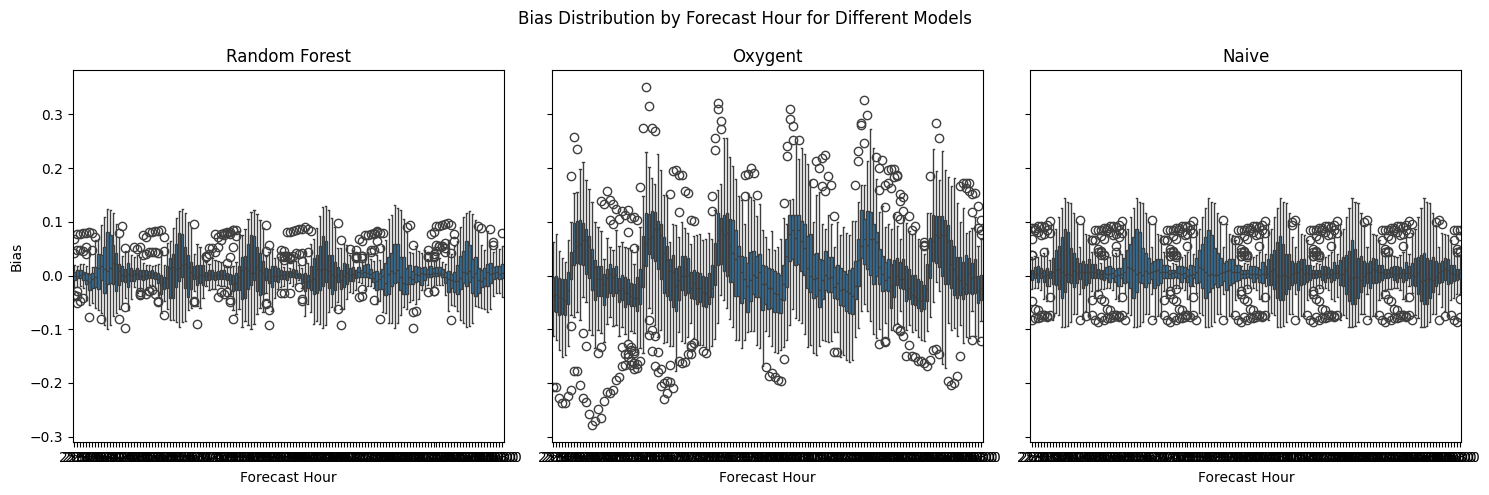

In [13]:
import seaborn as sns

import matplotlib.pyplot as plt

# 1. Add forecast_hour column
df['forecast_hour'] = (pd.to_datetime(df['target_datetime']) - pd.to_datetime(df['run_date'])).dt.total_seconds()/3600

# 2. Get min and max forecast hours
min_hour = df['forecast_hour'].min()
max_hour = df['forecast_hour'].max()
print(f"Forecast hours range from {min_hour:.0f} to {max_hour:.0f}")

# 3. Calculate bias and create plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Bias Distribution by Forecast Hour for Different Models')

models = ['predicted_Price', 'oxygent_price', 'naive_price']
names = ['Random Forest', 'Oxygent', 'Naive']

for i, (model, name) in enumerate(zip(models, names)):
    # Calculate bias
    df[f'bias_{model}'] = df[model] - df['actual_Price']
    
    # Create boxplot
    sns.boxplot(data=df, x='forecast_hour', y=f'bias_{model}', ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel('Forecast Hour')
    axes[i].set_ylabel('Bias' if i==0 else '')
    
plt.tight_layout()

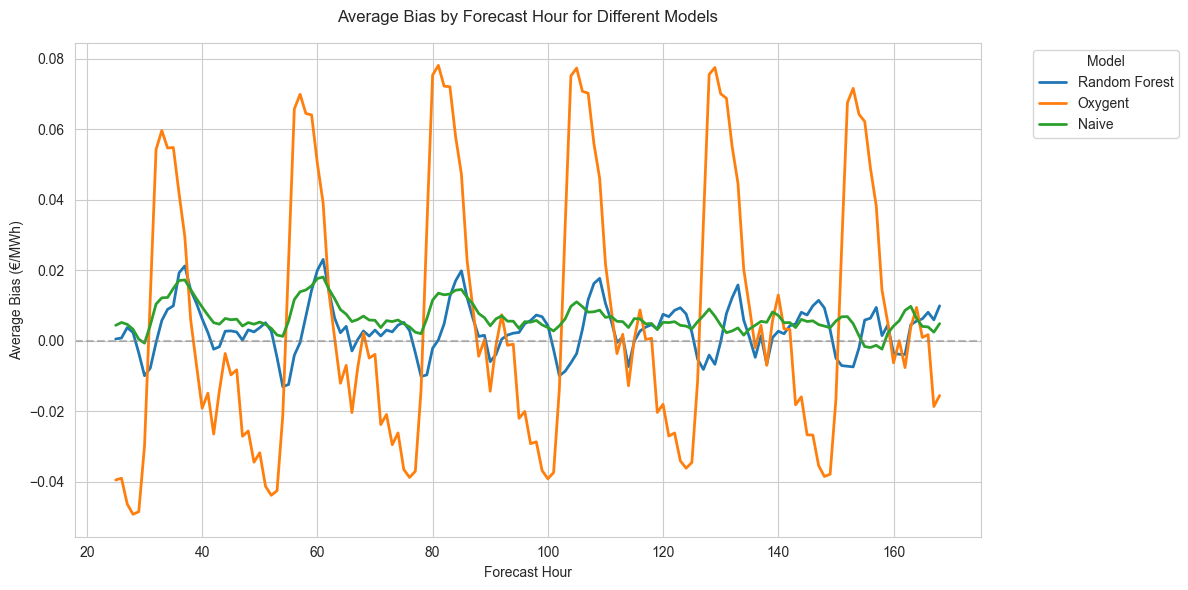

In [14]:
# Calculate mean bias per forecast hour for each model
bias_by_hour = pd.DataFrame({
    'Random Forest': df.groupby('forecast_hour')['bias_predicted_Price'].mean(),
    'Oxygent': df.groupby('forecast_hour')['bias_oxygent_price'].mean(),
    'Naive': df.groupby('forecast_hour')['bias_naive_price'].mean()
})

# Create the plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot lines for each model
for column in bias_by_hour.columns:
    plt.plot(bias_by_hour.index, bias_by_hour[column], label=column, linewidth=2)

# Add horizontal line at y=0
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Customize the plot
plt.title('Average Bias by Forecast Hour for Different Models', fontsize=12, pad=15)
plt.xlabel('Forecast Hour', fontsize=10)
plt.ylabel('Average Bias (€/MWh)', fontsize=10)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

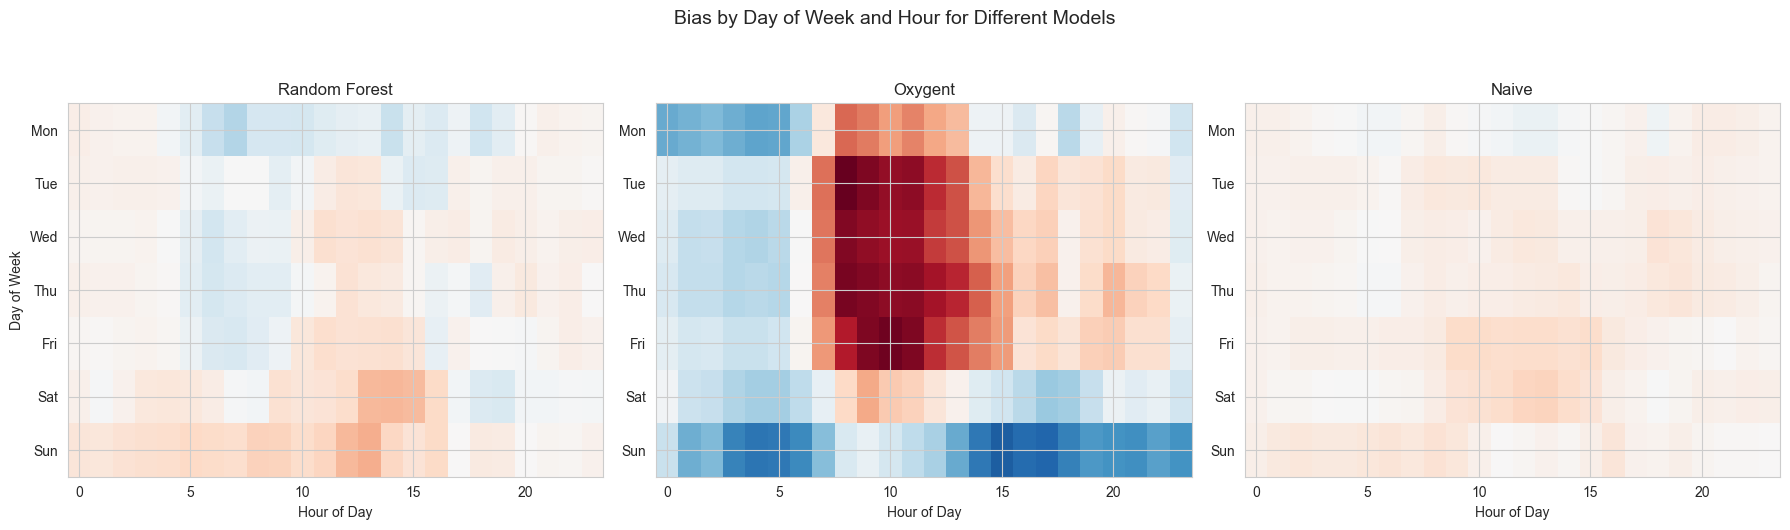

In [20]:
# Convert target_datetime to datetime and extract day of week and hour
df['day_of_week'] = pd.to_datetime(df['target_datetime']).dt.dayofweek
df['hour'] = pd.to_datetime(df['target_datetime']).dt.hour

# Calculate mean bias per day and hour for each model
bias_by_dayhour = pd.DataFrame()
for day in range(7):
    for hr in range(24):
        mask = (df['day_of_week'] == day) & (df['hour'] == hr)
        bias_by_dayhour.loc[f"{day}_{hr}", 'Random Forest'] = df[mask]['bias_predicted_Price'].mean()
        bias_by_dayhour.loc[f"{day}_{hr}", 'Oxygent'] = df[mask]['bias_oxygent_price'].mean()
        bias_by_dayhour.loc[f"{day}_{hr}", 'Naive'] = df[mask]['bias_naive_price'].mean()

# Create heatmap subplots for each model
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Bias by Day of Week and Hour for Different Models', fontsize=14, y=1.05)

models = ['Random Forest', 'Oxygent', 'Naive']
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Calculate global vmax for symmetric color scaling
vmax = max(abs(bias_by_dayhour.min().min()), abs(bias_by_dayhour.max().max()))

for i, (model, ax) in enumerate(zip(models, axes)):
    # Reshape data for heatmap: rows=days, columns=hours
    data = np.array([bias_by_dayhour[model][bias_by_dayhour.index.str.startswith(f"{d}_")].values for d in range(7)])
    ax.imshow(data, aspect='auto', cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    ax.set_title(model)
    ax.set_yticks(range(7))
    ax.set_yticklabels(day_labels)
    ax.set_xlabel('Hour of Day')
    if i == 0:
        ax.set_ylabel('Day of Week')

plt.tight_layout()
plt.show()

legend: colour scheme runs from -0.10 to + 0.10 € (darkest blue to darkest red)

/var/folders/6_/0hk4r2517rd0g1wg9893jqz40000gp/T/ipykernel_78938/2844905018.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


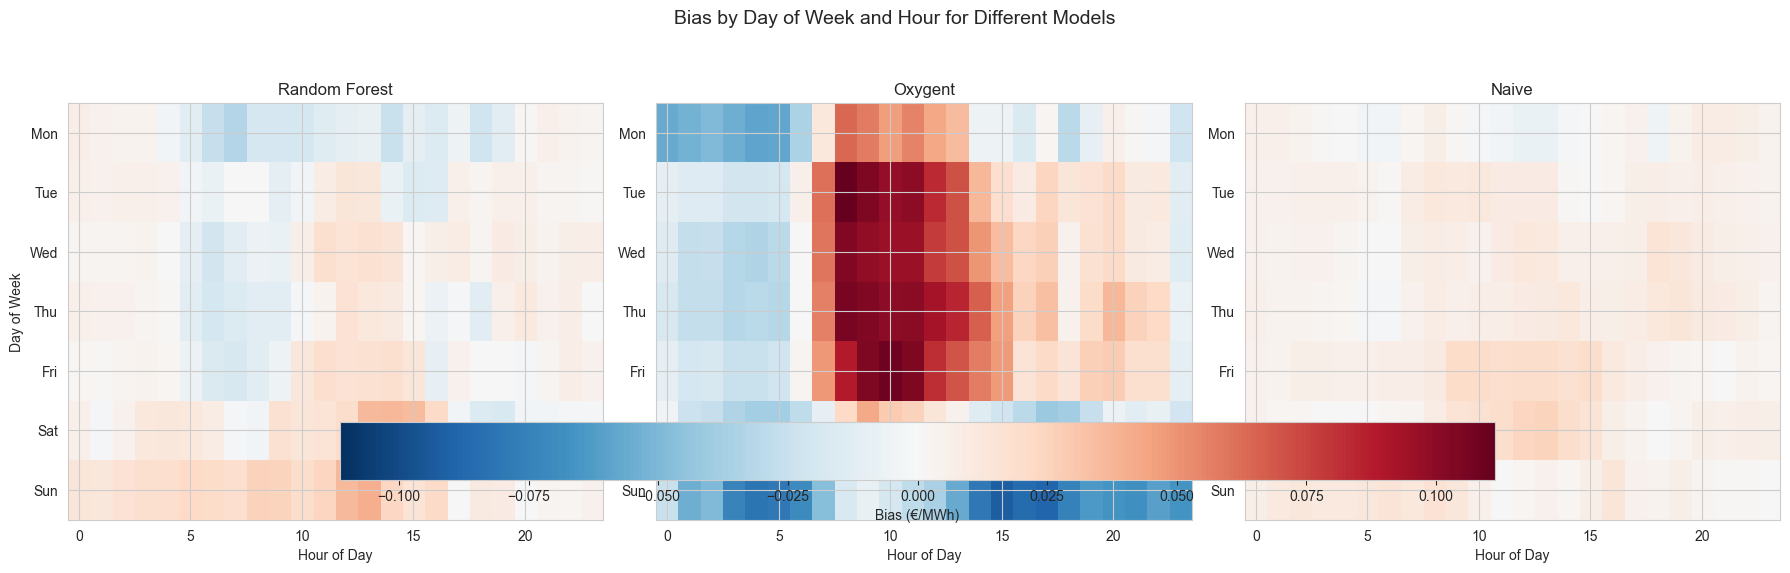

In [17]:
# Convert target_datetime to datetime and extract day of week and hour
df['day_of_week'] = pd.to_datetime(df['target_datetime']).dt.dayofweek
df['hour'] = pd.to_datetime(df['target_datetime']).dt.hour

# Calculate mean bias per day and hour for each model
bias_by_dayhour = pd.DataFrame()
for day in range(7):
    for hr in range(24):
        mask = (df['day_of_week'] == day) & (df['hour'] == hr)
        bias_by_dayhour.loc[f"{day}_{hr}", 'Random Forest'] = df[mask]['bias_predicted_Price'].mean()
        bias_by_dayhour.loc[f"{day}_{hr}", 'Oxygent'] = df[mask]['bias_oxygent_price'].mean()
        bias_by_dayhour.loc[f"{day}_{hr}", 'Naive'] = df[mask]['bias_naive_price'].mean()

# Create heatmap subplots for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Bias by Day of Week and Hour for Different Models', fontsize=14, y=1.05)

models = ['Random Forest', 'Oxygent', 'Naive']
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for i, (model, ax) in enumerate(zip(models, axes)):
    # Reshape data for heatmap
    data = np.array([bias_by_dayhour[model][bias_by_dayhour.index.str.startswith(f"{d}_")] for d in range(7)])
    
    
        
    # Create heatmap with symmetric color scaling
        # Calculate global vmax for symmetric color scaling
    vmax = max(abs(bias_by_dayhour.min().min()), abs(bias_by_dayhour.max().max()))
    
    # Create heatmap with symmetric color scaling
    im = ax.imshow(data, aspect='auto', cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    
    # Customize appearance
    ax.set_title(model)
    ax.set_yticks(range(7))
    ax.set_yticklabels(day_labels)
    ax.set_xlabel('Hour of Day')
    if i == 0:
        ax.set_ylabel('Day of Week')
    
    # Customize appearance
    ax.set_title(model)
    ax.set_yticks(range(7))
    ax.set_yticklabels(day_labels)
    ax.set_xlabel('Hour of Day')
    if i == 0:
        ax.set_ylabel('Day of Week')
    
# Add colorbar
plt.colorbar(im, ax=axes, label='Bias (€/MWh)', orientation='horizontal', pad=0.15)

plt.tight_layout()
plt.show()